# Imports and overview

This notebook implements the CORAL model from https://arxiv.org/pdf/1511.05547.pdf. It is inspired from https://github.com/SSARCandy/DeepCORAL.

In [151]:
# We can now load the dependencies
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torchmetrics
import os
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

We can start by setting a seed for reproducibility

In [152]:
torch.manual_seed(0)

For reference, here is the architecture of the model we will implement:

<img src="CORAL_architecture.png" align="center"/>

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once.

In [153]:
# Transform to apply to the minibatches for data augmentation
# Define the transformation to apply
# Transformations: Random horizontal and vertical flips, halving and doubling the brightness
# This should improve the prediction accuracy
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomApply([transforms.ColorJitter(brightness=[0.75, 1.25])], p=0.5)
])

class CustomDataset(Dataset):
    
    def __init__(self, root_dir, label_dir):
        self.root_dir = root_dir
        self.label_dir = label_dir
        self.images = os.listdir(root_dir)
        self.labels = torch.load(label_dir).long()

        # Remove the labels that do not belong to this split of the dataset (Labels is all labels)
        self.labels = self.labels[torch.tensor([int(img_name[3:9]) for img_name in self.images])]



    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root_dir, img_name)
        image = Image.open(img_path)
        image = transform(image)
        label = self.labels[idx] # Since we removed the labels that do not belong to this split, we can use idx directly
        return image, label

# Extract the generated data
generated_data_root = "../../Data Generation/Pre Processed Data Generated"
train_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Training", generated_data_root + "/Square Images/y_generated.pt")
val_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Validation", generated_data_root + "/Square Images/y_generated.pt")
test_gen_dataset = CustomDataset(generated_data_root + "/Square Images/Testing", generated_data_root + "/Square Images/y_generated.pt")

# Extract the real data
real_data_root = "../../Real life data/Pre processed Real Life"
train_real_dataset = CustomDataset(real_data_root + "/Square Images/Training", real_data_root + "/Square Images/y_real_life.pt")
val_real_dataset = CustomDataset(real_data_root + "/Square Images/Validation", real_data_root + "/Square Images/y_real_life.pt")
test_real_dataset = CustomDataset(real_data_root + "/Square Images/Testing", real_data_root + "/Square Images/y_real_life.pt")

# Hyperparameter choices

We create a cell to hold the hyperparameters of the model

In [154]:
learning_rate = 0.001
batch_size = 100 # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
num_epochs = 1 # Since we only train on generated data, we can use a small number of epochs because we have around 300000 images plus the augmentation
dropout_rate_choices = {0.2, 0.5}
gamma_focal_loss_choices = {2, 5} # Choices for the gamma parameter in the focal loss
n_validation = 10 # Number of iterations between each validation run
n_validation_minibatches = 2 # Number of minibatches to use for validation
n_final_validation_minibatches = 20 # Number of minibatches to use for the final validation run
lambda_coral_choices = {1, 0.5} # Regularization parameter for CORAL

# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [155]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [156]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [157]:
class CoralModel(nn.Module):

    def __init__(self, num_classes=13, dropout_rate=0.5):
        
        super(CoralModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Set the features to not require gradients
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Training

We can start by finding the device to use for training:

In [158]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE == "cuda":
    torch.cuda.empty_cache()

We can then go ahead and define the loss function we will be using. 

According to the specified model architecture, the CORAL model utilizes two loss functions. The first one is the classification loss, for whihc we will opt for a balanced focal loss rather than the regular cross-entropy loss. The aim is to assign greater importance to the classes that are more challenging to classify. The focal loss can be defined using the following formula:

$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.


The second loss is the Coral loss. Coral loss is a type of distance metric used to align two sets of feature representations. It stands for "correlation alignment".

The Coral loss aims to minimize the domain shift between two distributions by aligning the second-order statistics of their features. It computes the covariance matrix of the source and target features and then minimizes the Frobenius norm between the difference of the two covariance matrices. This way, the correlation between the features is preserved and domain shift is reduced.

The Coral loss can be formulated as:

$$
L_{coral}(X_s, X_t) = \lVert C_s - C_t \rVert_{F}^2
$$

where $X_s$ and $X_t$ are the source and target feature representations respectively, and $C_s$ and $C_t$ are the covariance matrices of the source and target features.

In addition to the loss function, a helper function can be defined to compute the covariance matrix:

$$
C(X) = \frac{1}{n-1}(X-\bar{X})^T(X-\bar{X})
$$

where $X$ is a matrix of feature representations and $\bar{X}$ is the mean of each feature. The following code is taken from the mentionned github repository: https://github.com/SSARCandy/DeepCORAL.

In [159]:
# def CORAL(source, target):
#     d = source.data.shape[1]

#     # source covariance
#     xm = torch.mean(source, 0, keepdim=True) - source
#     xc = xm.t() @ xm

#     # target covariance
#     xmt = torch.mean(target, 0, keepdim=True) - target
#     xct = xmt.t() @ xmt

#     # frobenius norm between source and target
#     loss = torch.mean(torch.mul((xc - xct), (xc - xct)))
#     loss = loss/(4*d*d)

#     return loss

def CORAL(source_features, target_features):
    source_cov = torch.matmul(source_features.T, source_features)
    target_cov = torch.matmul(target_features.T, target_features)
    loss = torch.mean(torch.square(source_cov - target_cov))
    return loss

The total loss used in the backward step of our model is therefore represented by the following equation:

$$
TotalLoss = ClassificationLoss + \lambda DomainLoss
$$
$$
TotalLoss = FC + \lambda L_{coral}(X_s, X_t)
$$

We also adjust the hyperparameter $\lambda$, which determines the weight of the coral loss term in the total loss function." In other words, $\lambda$ controls the contribution of the coral loss to the overall loss value, with larger values of $\lambda$ giving the coral loss term more weight in the optimization process.

Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [160]:
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

Finally, because we are using balanced accuracy scores, we can use the class analytics gathered during pre-processing to define the following class distribution array:

In [161]:
class_proportions_gen = np.array([0.3198, 0.1602, 0.0405, 0.0400, 0.0406, 0.0201, 0.0404, 0.1596, 0.0392, 0.0397, 0.0400, 0.0196, 0.0404])
class_proportions_real = np.array([0.3228, 0.1738, 0.0347, 0.0415, 0.0454, 0.0206, 0.0354, 0.1490, 0.0284, 0.0463, 0.0432, 0.0234, 0.0354])

# Print the sum of the class proportions as a sanity check
print(class_proportions_gen.sum())
print(class_proportions_real.sum())

1.0001
0.9998999999999999


 We can now proceed to defining a function that creates a data loader for both datasets, oversampling the minority classes and applying horizontal flip and blur transformations:


In [162]:
def get_gen_loader(dataset, batch_size):

    # Define the sampler
    class_weights = 1. / torch.tensor(class_proportions_gen, dtype=torch.float) # The weights of the classes
    sample_weights = class_weights[dataset.labels] # Assign each label its corresponding weight
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

def get_real_loader(dataset, batch_size):

    # Define the sampler
    class_weights = 1. / torch.tensor(class_proportions_real, dtype=torch.float) # The weights of the classes
    sample_weights = class_weights[dataset.labels] # Assign each label its corresponding weight
    sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

    return DataLoader(dataset, batch_size=batch_size, sampler=sampler)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

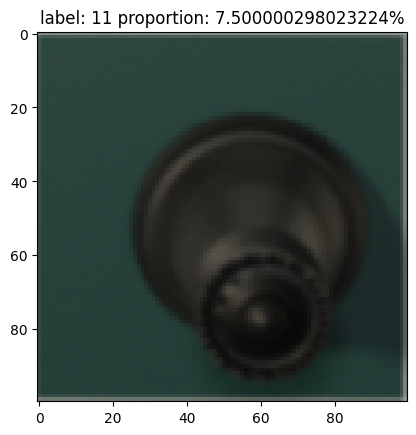

In [163]:
gen_train_loader = get_gen_loader(train_gen_dataset, batch_size=200)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following function for plotting the metrics collected during training:

In [164]:
def plot_and_save_metrics(gen_training_losses, class_losses, domain_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate):

    validation_x_axis = np.arange(0, len(gen_validation_losses) * n_validation, n_validation)

    plt.figure(figsize=(30, 30))

    plt.subplot(3, 2, 1)
    plt.plot(gen_training_losses, label="Total Loss")
    plt.plot(class_losses, label="Classification Loss")
    plt.plot(domain_losses, label="Domain Loss")
    plt.title("Training Losses (Total, Classification and Domain Losses)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(3, 2, 2)
    plt.plot(gen_training_accs)
    plt.title("Training Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")

    plt.subplot(3, 2, 3)
    plt.plot(gen_training_f1s)
    plt.title("Training weighted F1 scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 score")

    plt.subplot(3, 2, 4)
    plt.plot(validation_x_axis, gen_validation_losses, label="Source domain")
    plt.plot(validation_x_axis, real_validation_losses, label="Target domain")
    plt.title("Validation Losses")
    plt.xlabel("Iteration")
    plt.ylabel("Focal loss")
    plt.legend()

    plt.subplot(3, 2, 5)
    plt.plot(validation_x_axis, gen_validation_accs, label="Source domain")
    plt.plot(validation_x_axis, real_validation_accs, label="Target domain")
    plt.title("Validation Accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(3, 2, 6)
    plt.plot(validation_x_axis, gen_validation_f1s, label="Source domain")
    plt.plot(validation_x_axis, real_validation_f1s, label="Target domain")
    plt.title("Validation weighted F1 Scores")
    plt.xlabel("Iteration")
    plt.ylabel("Weighted F1 Score")
    plt.legend()

    plt.suptitle("Hyperparameters: gamma: " + str(gamma) + ", batch_size: " + str(batch_size) + ", dropout_rate: " + str(dropout_rate), fontsize=24)
    
    plt.savefig("HP tuning results/" + "gamma_" + str(gamma) + "_batch_" + str(batch_size) + "_dropout_" + str(dropout_rate) + ".png",  facecolor='white', transparent=False)
    plt.close()

We can now proceed to train our model:

In [165]:
# To store the best model
best_model = None
best_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Gamma", "Batch size", "Dropout rate", "Final validation accuracy"])

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:

        for lambda_coral in lambda_coral_choices:
            # Define the data loaders accounting for the batch size
            gen_train_loader = get_gen_loader(train_gen_dataset, batch_size=batch_size)
            gen_val_loader = get_gen_loader(val_gen_dataset, batch_size=batch_size)
            gen_test_loader = get_gen_loader(test_gen_dataset, batch_size=batch_size)
            real_train_loader = get_real_loader(train_real_dataset, batch_size=batch_size)
            real_val_loader = get_real_loader(val_real_dataset, batch_size=batch_size)
            real_test_loader = get_real_loader(test_real_dataset, batch_size=batch_size)

            # Define the new loss function (Taking into account gamma)
            focal_loss = torch.hub.load(
                'adeelh/pytorch-multi-class-focal-loss',
                model='FocalLoss',
                gamma=gamma, # No use of alpha since we have balanced classes now with the oversampling
                reduction='mean',
                force_reload=False,
                verbose = False
            ).to(DEVICE)

            # To store the metrics through epochs
            gen_training_losses = []
            gen_training_accs = []
            gen_training_f1s = []
            gen_validation_losses = []
            gen_validation_accs = []
            gen_validation_f1s = []
            real_validation_losses = []
            real_validation_accs = []
            real_validation_f1s = []
            class_losses = []
            domain_losses = []

            # Define the model and the optimizer
            coralmodel = CoralModel(dropout_rate=dropout_rate).to(DEVICE)
            opt = optim.Adam(coralmodel.parameters(), lr=learning_rate)
            
            for epoch in range(num_epochs):
                
                # Train the model
                for iteration, ((X_train_gen, y_train_gen), (X_train_real, _)) in tqdm(enumerate(zip(gen_train_loader, real_train_loader)), total=len(gen_train_loader)):
                    
                    # Set the model to training mode
                    coralmodel.train()

                    # Move the data to the device
                    X_train_gen = X_train_gen.to(DEVICE)
                    y_train_gen = y_train_gen.to(DEVICE)

                    # Forward pass for source data (Generated data)
                    y_train_pred_raw_gen = coralmodel(X_train_gen)
                    y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

                    # Forward pass for target data (Real data)
                    y_train_pred_raw_real = coralmodel(X_train_real)
                    y_train_pred_real = torch.argmax(y_train_pred_raw_real, dim=1)

                    # Compute the classification loss (Focal loss)
                    loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

                    # Compute the domain loss (CORAL loss)
                    domain_loss = CORAL(y_train_pred_raw_gen, y_train_pred_raw_real)

                    # Get the total loss
                    total_loss = loss_train + lambda_coral * domain_loss

                    # Compute the accuracy
                    acc_train = accuracy(y_train_pred_gen, y_train_gen)
                    f1_train = f1_score(y_train_pred_gen, y_train_gen)

                    # Backward pass
                    opt.zero_grad()
                    total_loss.backward()
                    opt.step()

                    # Store the loss & accuracy
                    gen_training_losses.append(total_loss.item())
                    gen_training_accs.append(acc_train.item())
                    gen_training_f1s.append(f1_train.item())
                    
                    # Store corresponding class and domain losses
                    class_losses.append(loss_train.item())
                    domain_losses.append(domain_loss.item())
                    
                    # Check if the model should be validated
                    if iteration == 0 or (iteration + 1) % n_validation == 0:
                        
                        # Set the model to evaluation mode
                        coralmodel.eval()
                        
                        # Disable gradient calculation
                        with torch.no_grad():

                            # 1) Evaluate on the generated validation set
                            acc_val_sum = 0
                            weighted_f1_val_sum = 0
                            loss_val_sum = 0

                            # Extract an iterator from the generated data loader
                            gen_val_iter = iter(gen_val_loader)

                            # Iterate for n_validation_minibatches
                            for i in range(n_validation_minibatches):

                                # Get the next minibatch
                                X_val_gen, y_val_gen = next(gen_val_iter)
                                    
                                # Move the data to the device
                                X_val_gen = X_val_gen.to(DEVICE)
                                y_val_gen = y_val_gen.to(DEVICE)

                                # Forward pass
                                y_val_pred_raw_gen = coralmodel(X_val_gen)
                                y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                                # Compute the metrics
                                acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                                weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                                loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen)

                            # Compute the average metrics
                            acc_val_gen = acc_val_sum / n_validation_minibatches
                            loss_val_gen = loss_val_sum / n_validation_minibatches
                            weighted_f1_val_gen = weighted_f1_val_sum / n_validation_minibatches

                            # 2) Repeat on the real validation set
                            acc_val_sum = 0
                            weighted_f1_val_sum = 0
                            loss_val_sum = 0

                            # Extract an iterator from the generated data loader
                            real_val_iter = iter(real_val_loader)

                            # Iterate for n_validation_minibatches
                            for i in range(n_validation_minibatches):

                                # Get the next minibatch
                                X_val_real, y_val_real = next(real_val_iter)
                                    
                                # Move the data to the device
                                X_val_real = X_val_real.to(DEVICE)
                                y_val_real = y_val_real.to(DEVICE)

                                # Forward pass
                                y_val_pred_raw_real = coralmodel(X_val_real)
                                y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                                # Compute the metrics
                                acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                                weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)
                                loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real)

                            # Compute the average metrics
                            acc_val_real = acc_val_sum / n_validation_minibatches
                            loss_val_real = loss_val_sum / n_validation_minibatches
                            weighted_f1_val_real = weighted_f1_val_sum / n_validation_minibatches

                            # Store all 6 metrics
                            gen_validation_losses.append(loss_val_gen.item())
                            gen_validation_accs.append(acc_val_gen.item())
                            gen_validation_f1s.append(weighted_f1_val_gen.item())
                            real_validation_losses.append(loss_val_real.item())
                            real_validation_accs.append(acc_val_real.item())
                            real_validation_f1s.append(weighted_f1_val_real.item())

                            # Print an update
                            print('----------------------------------------------------------------')
                            print(f'EPOCH [{epoch + 1}], ITERATION [{iteration+1}]')
                            print(f'TRAINING => Total Loss: {total_loss}, Classification Loss: {loss_train}, CORAL loss: {domain_loss}, Training accuracy: {acc_train}, Training weighted F1: {f1_train}')
                            print(f'GENERATED VALIDATION => Loss: {loss_val_gen}, Validation accuracy: {acc_val_gen}, Validation weighted F1: {weighted_f1_val_gen}')
                            print(f'REAL VALIDATION => Loss: {loss_val_real}, Validation accuracy: {acc_val_real}, Validation weighted F1: {weighted_f1_val_real}')
                            print('----------------------------------------------------------------')

                # Save the model every epoch as a checkpoint 
                torch.save(coralmodel.state_dict(), f'./checkpoints/coralmodel_gamma_{gamma}_dropout_{dropout_rate}_batch_{batch_size}_epoch_{epoch+1}.ckpt')


            # Evaluate the final real life validation accuracy

            # Set the model to evaluation mode
            coralmodel.eval()
            acc_val_sum = 0

            # Create an iterator
            real_val_iter = iter(real_val_loader)

            # Disable gradient calculation
            with torch.no_grad():
                
                for i in range(n_final_validation_minibatches):

                    # Get the next minibatch
                    minibatch = next(real_val_iter, None)
                    if minibatch is None:
                        real_val_iter = iter(real_val_loader)
                        minibatch = next(real_val_iter, None)
                    X_val_real, y_val_real = minibatch

                    # Move the data to the device
                    X_val_real = X_val_real.to(DEVICE)
                    y_val_real = y_val_real.to(DEVICE)

                    # Forward pass
                    y_val_pred_prob_real = coralmodel(X_val_real)
                    y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

                    # Compute the metrics
                    acc_val_sum += accuracy(y_val_pred_real, y_val_real)

            # Compute the average accuracy
            final_real_val_acc = acc_val_sum / n_final_validation_minibatches

            # Create a row to add to the dataframe
            row = [gamma, batch_size, dropout_rate, final_real_val_acc.cpu().item()]

            # Store it
            hp_final_accs.loc[len(hp_final_accs)] = row

            # Compare to the best model
            if best_model is None or best_acc < final_real_val_acc:
                best_model = coralmodel
                best_acc = final_real_val_acc
                torch.save(coralmodel.state_dict(), f'./best_model.ckpt')

            # Plot and save the metrics
            plot_and_save_metrics(gen_training_losses, class_losses, domain_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, real_validation_f1s, gamma, batch_size, dropout_rate)

# Save the dataframe as a table
hp_final_accs.to_csv('HP_final_accuracies.csv', index=False)


  0%|          | 1/893 [01:34<23:29:09, 94.79s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [1]
TRAINING => Total Loss: 2.193307876586914, Classification Loss: 2.1906540393829346, CORAL loss: 0.005307438783347607, Training accuracy: 0.07999999076128006, Training weighted F1: 0.05799185484647751
GENERATED VALIDATION => Loss: 2.074993133544922, Validation accuracy: 0.17499999701976776, Validation weighted F1: 0.09228627383708954
REAL VALIDATION => Loss: 2.182999610900879, Validation accuracy: 0.06499999761581421, Validation weighted F1: 0.024961411952972412
----------------------------------------------------------------


  1%|          | 10/893 [07:28<12:53:45, 52.58s/it]

----------------------------------------------------------------
EPOCH [1], ITERATION [10]
TRAINING => Total Loss: 2.0820584297180176, Classification Loss: 2.0324716567993164, CORAL loss: 0.099173404276371, Training accuracy: 0.25999999046325684, Training weighted F1: 0.18926988542079926
GENERATED VALIDATION => Loss: 2.0567946434020996, Validation accuracy: 0.30000001192092896, Validation weighted F1: 0.21208830177783966
REAL VALIDATION => Loss: 2.0992820262908936, Validation accuracy: 0.23000000417232513, Validation weighted F1: 0.15463003516197205
----------------------------------------------------------------


  2%|▏         | 18/893 [11:49<8:19:56, 34.28s/it] 

After this code runs, the best model can be found in the directory of the script.